In [38]:
import numpy as np          
import pandas as pd    
from random import randint
from tqdm import tqdm    
import cv2
import matplotlib.pyplot as plt
from subprocess import check_output
import PIL
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

Any results you write to the current directory are saved as output.

In [ ]:
print(check_output(["ls", "./input"]).decode("utf8"))

Load Labels Data & Analyse Data

In [ ]:
df_train = pd.read_csv("./labels.csv")
print(df_train.shape)
df_train.head(10)

Visualise Data / Visualize the number of each breeds

In [ ]:
breeds_all = df_train["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

In [34]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        # Plot image.
        
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width,img_height,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

Load Data

In [39]:
img_width=250
img_height=250
images=[]
classes=[]
#load training images
for f, breed in tqdm(df_train.values):
    img = cv2.imread('./train/{}.jpg'.format(f))
    classes.append(breed)
    images.append(cv2.resize(img, (img_width, img_height)))

100%|██████████| 10222/10222 [01:04<00:00, 157.85it/s]


Plot Example Images With Random

[736, 5209, 339, 7469, 74, 149, 5426, 1818, 8542]
Images to show: 9
Classes to show: 9


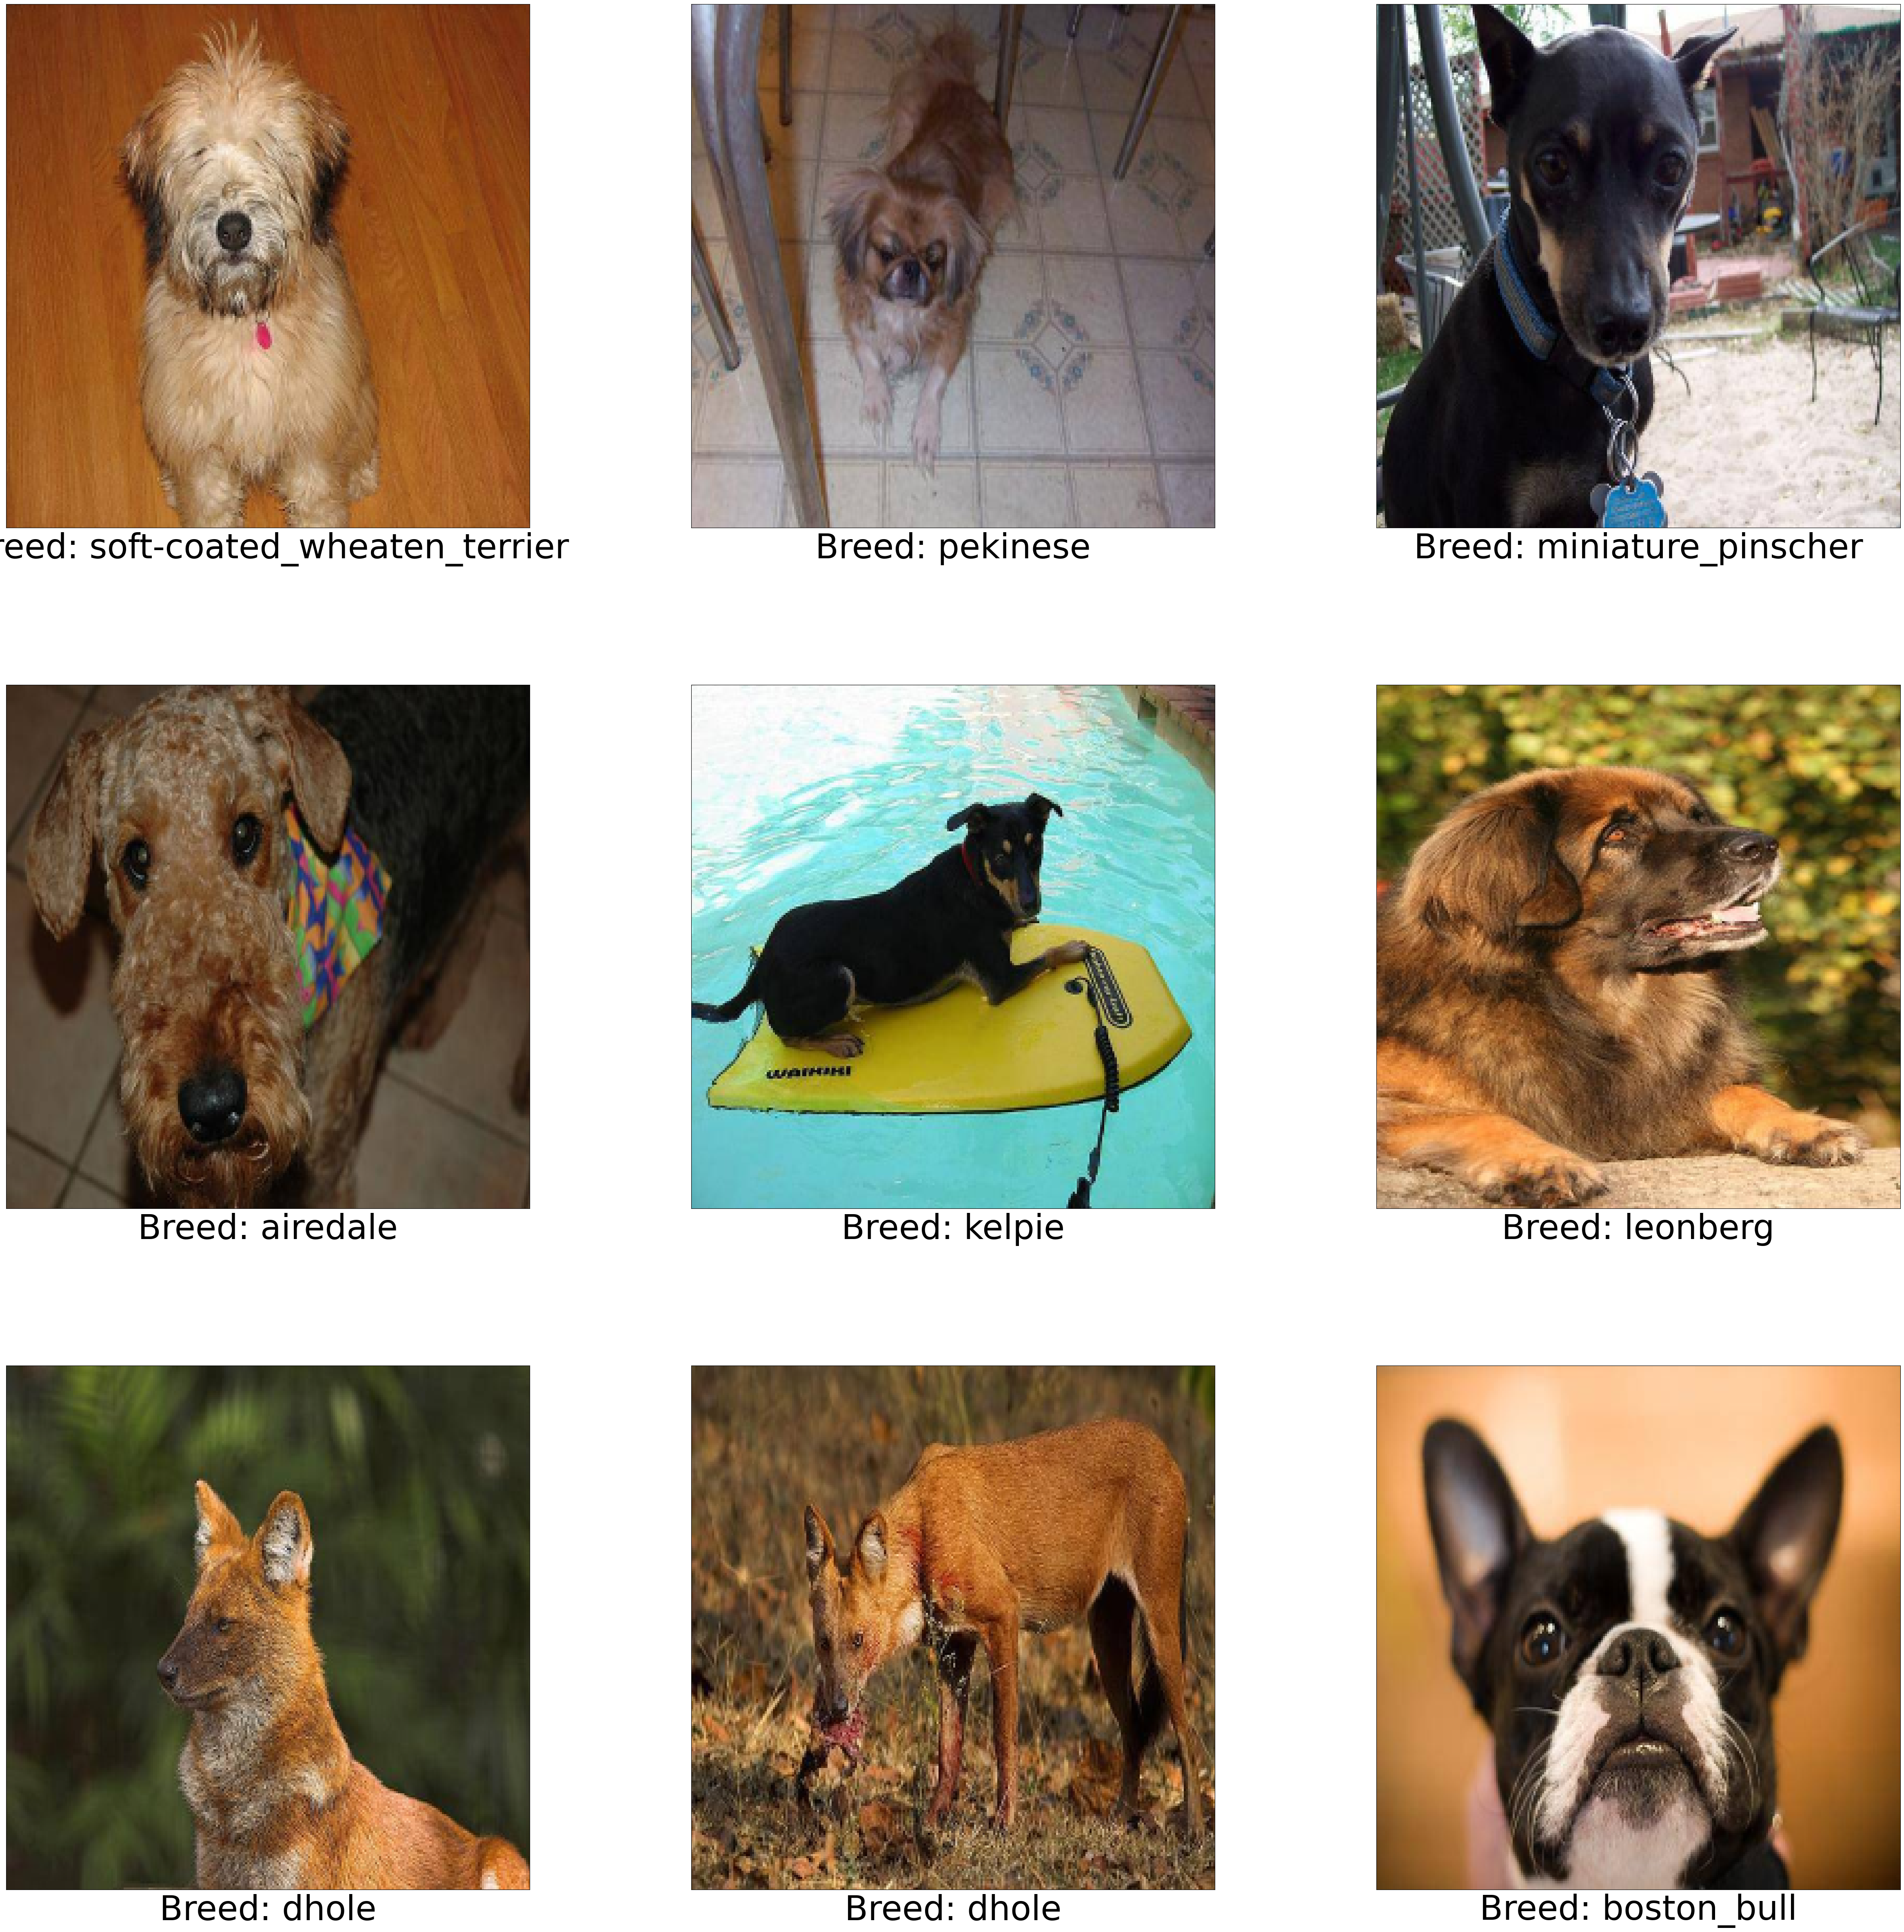

In [40]:
random_numbers = [randint(0, len(images)) for p in range(0,9)]
print(random_numbers)
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))

#plot images
plot_images(images_to_show, classes_to_show)

Select Dog Breeds (Only 3 are permitted)

In [36]:
CLASS_NAMES = ['american_staffordshire_terrier','rottweiler','bull_mastiff'] #Insert 3 dog breeds here (3 is the limitation of the computation power)
labels = df_train[(df_train['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

index                                id                           breed
0    112  02ad779f2721db9364d3bb68f5580582                    bull_mastiff
1    117  02d45a238621c3f2cbde5c1d173ead1e                    bull_mastiff
2    125  02f3d5fd1eea0a2e6f4742bc54b51ba9  american_staffordshire_terrier
3    175  041d0d6a8d110b35a3795dd5c68f9a36  american_staffordshire_terrier
4    178  042e83e82315bada78f2681d030b0d28                    bull_mastiff

In [41]:
#Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')

Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

#Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('../input/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
#Printing train images
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

  0%|          | 0/225 [00:00<?, ?it/s]


AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

One Hot encode the target value &  Read images and convert them into numpy array and finally normalizing the array.

In [42]:
#Model Build
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])


Network Architecture Model

In [43]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

Test Model and Train Data

In [44]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 43s 10s/step - loss: 4.8912 - accuracy: 0.3230 - val_loss: 4.8684 - val_accuracy: 0.3659
Epoch 2/100
2/2 [==============================] - 29s 5s/step - loss: 4.8658 - accuracy: 0.3416 - val_loss: 4.8431 - val_accuracy: 0.2683
Epoch 3/100


Train model on 100 epochs and a batch size of 128. Can increase accuracy of the number of epochs

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['acc'], color='r')
plt.plot(history.history['val_acc'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Analyse how the model is learning with each epoch in terms of accuracy.

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Use predict function to make predictions using this model also we are finding out the accuracy on the test set.

In [ ]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])